<a href="https://colab.research.google.com/github/bobby-he/Neural_Tangent_Kernel/blob/master/notebooks/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Tangent Kernel

## Introduction

Despite widespread practical success, the training behaviour of Deep Neural Networks (DNNs) has always been a poorly understood concept. Much focus has been placed on understanding convergence in parameter space, but it is well known that  the loss surface of DNNs are a high dimensional  and non-convex. They contain many saddle-points, valleys and symmetries that render it unreasonable to expect that a gradient based optimiser will be able to converge to the global minimum, if one exists.  In spite of this, DNNs are also known for their good generalisation properties, despite their seemingly obvious over-parametrisation. 

This report will study some recent papers that aim to shed light on the dyanmics of DNN training. The main idea involved is to view the training process in terms of the function $f_{\theta}$ that the DNN represents instead of the parameters $\theta$

Consider a fully connected, feed-forward neural network with layers numbered from $0$ (input) to $L$ (output), each layer has width $n_0, \dots, n_L$ respectively. Denote the training set by $\mathcal{D} \subseteq \mathbb{R}^{n_0} \times \mathbb{R}^{n_L}$, and let $\mathcal{X}=\{ x : (x,y) \in \mathcal{D} \}$ and $\mathcal{Y}=\{ y : (x,y) \in \mathcal{D} \}$ be the inputs and labels of the neural network. Following the parametrisation used by [Jacot et al. (2018)][1], the recurrence relation of the neural network can then be described as 
\begin{align}
\alpha^{(0)} (x; \theta) &= x \\
\tilde{\alpha}^{(l+1)} (x ; \theta) &= \frac{1}{\sqrt{n_l}} W^{(l)} \alpha^{(l)} (x; \theta) + \beta b^{(l)} \\
\alpha^{(l)} (x; \theta) &= \sigma (\tilde{\alpha}^{(l)} (x ; \theta)) 
\end{align}
where the functions $\tilde{\alpha}^{(l)}(\cdot; \theta):\mathbb{R}^{n_o} \to \mathbb{R}^{n_l}$ and $\alpha^{(l)} (\cdot; \theta):\mathbb{R}^{n_o} \to \mathbb{R}^{n_l} $ are the preactivations and activations at layer $l$. The nonlinearity $\sigma : \mathbb{R} \to \mathbb{R}$ is applied entrywise, and the parameters $\theta$ consists of all the variables contained in the connection matrices $W^{(l)} \in \mathbb{R}^{n_l \times n_{l+1}}$ and the bias vectors $b^{(l)} \in \mathbb{R}^{n_{l+1}}$ for $l=0, \dots, L-1$; $\theta$ is initialised randomly as i.i.d. standard Gaussian random variables, and trained using gradient descent. As the width of the hidden layers $n_1, \dots, n_{L-1}$ grow to infinity, the factors $\frac{1}{\sqrt{n_l}}$ ensure a consistent asymptotic behavior is obtained from the neural network, while the factor $\beta$ is introduced to balance the influence of the connection weights and bias when $n_l$ is large. 

The dimension of the parameter space is $P=\sum_{l=0}^{L-1} (n_l + 1)n_{L+1}$, and denote $\mathcal{F}=\{f:\mathbb{R}^{n_0} \to \mathbb{R}^{n_L} \}$ to be the function space. For a functional cost $C:\mathcal{F} \to \mathbb{R}$, the composite cost $C \circ F : \mathbb{R}^{P} \to \mathbb{R}$ is generally highly non-convex even for a convex $C$, making the study of behaviours of parameters during training difficult. [Jacot et al. (2018)][1] focuses on the realisation function $F^{(L)}:\mathbb{R}^P \to \mathcal{F}$ that maps parameters $\theta$ to functions $f_{\theta} \in \mathcal{F}$, and the network function $f_{\theta}(x) := \tilde{\alpha}^{(L)} (x ; \theta)$ computed by the neural network instead of the parameters $\theta$.

Let $p^{in}$ be a distribution on the input space $\mathbb{R}^{n_0}$. On the function space, consider the seminorm $\|\cdot\|_{p^{in}}$ induced from the bilinear form  
\begin{align}
\langle f,g \rangle_{p^{in}}=\mathbb{E}_{x \sim p^{in}}\Bigl[f(x)^Tg(x)\Bigr]
\end{align}
and the set $\mathcal{F}^*$ containing linear forms $\mu: \mathcal{F} \to \mathbb{R}$ where $\mu=\langle d, \cdot \rangle_{p^{in}}$ for some $d \in \mathcal{F}$. For a finite input $x_1, \dots, x_n \in \mathbb{R}^{n_0}$, the functional derivative of the cost $C$ at a point $f_0 \in \mathcal{F}$ is then an element in $\mathcal{F}^*$, and has a corresponding element $d|_{f_0} \in \mathcal{F}$ such that $\partial_f C|_{f_0} = \langle d|_{f_0} , \cdot \rangle_{p^{in}}$. Let $K:\mathbb{R}^{n_0} \times \mathbb{R}^{n_0} \to \mathbb{R}^{n_L \times n_L}$ be a multi-dimensional kernel such that $K(x, x')=K(x',x)^T$, then $K$ is positive definite with respect to $\| \cdot \|_{p^{in}}$ if $\| f \|_{p^{in}}> 0 \Rightarrow \|f||_K >0$, where for independent $x, x' \sim p^{in}$, $\langle f, g \rangle_K := \mathbb{E}_{x, x' \sim p^{in}}[f(x)^T K(x,x')g(x')]$.





[1]:(https://arxiv.org/abs/1806.07572)
[2]:(https://arxiv.org/abs/1902.04760)
[3]:(https://arxiv.org/abs/1902.06720) 


[Jacot et al. (2018)][1]

[Yang (2019)][2]

[Lee et al. (2019)][3]

[1]:(https://arxiv.org/abs/1806.07572)
[2]:(https://arxiv.org/abs/1902.04760)
[3]:(https://arxiv.org/abs/1902.06720) 



## Theoretical considerations on the linearized network. 



### Linearized networks

A second paper ([Lee et al. (2019)][2]) builds on the results obtained by the one described above, and introduces an approximated linearized expansion of the network, namely a Taylor expansion of the network function at the first order in the weight variation. Specifically, if we denote as $f_t(x)$ the network function at time $t$ and $\theta$ as the parameters of the network, we can define the first order expansion of the network function as: 

$$f_t^{lin}(x) = f_0(x) + \nabla_{\theta} f_0(x) \omega_t,$$

where $\omega_t = \theta_t - \theta_0$ is the change of parameters from their initial values. 

In the framework of supervised learning, we are interested in minimizing the empirical loss: 

$$\mathcal L = \frac{1}{|\mathcal D|}\sum_{(x,y) \in \mathcal D} l(f_t(x, \theta), y), $$

where $\mathcal l(y, \hat y)$ denotes the loss function between the true label $y$ and the prediction $\hat y$. Note that the above definition, in the notation of [Jacot et al. (2018)][1], corresponds to $(C \circ F^{(L)}) (\theta(t)) = \mathcal L$. 

By using this notation, under continuous time gradient descent the parameters and outputs of the network evolve in the following way: 


$$\partial_t \theta_t = - \eta \nabla_{\theta} f_t(\mathcal X)^T \nabla_{f_t(\mathcal X)} \mathcal L$$

$$\partial_t f_t(\mathcal X) = - \eta\  \hat \Theta_t(\mathcal X, \mathcal X) \nabla_{f_t(\mathcal X)} \mathcal L$$

where $f_t(\mathcal X)$ is the vector of concatenated outputs with respect to all examples in the training set $\mathcal X$ and $\hat \Theta_t  \equiv  \hat \Theta_t(\mathcal X, \mathcal X)$ is the tangent kernel at time $t$ evaluated on the training set. We also define the tangent kernel between a generic input $x$ and the training set $\mathcal X$ as $\hat \Theta_t(x, \mathcal X)$. 

When considering the linearized function, the evolution equation of the network take the following form: 

$$\partial_t \omega_t = - \eta \nabla_{\theta} f_0(\mathcal X)^T \nabla_{f^{lin}_t(\mathcal X)} \mathcal L$$

$$\partial_t f^{lin}_t(\mathcal X) = - \eta\  \hat \Theta_0(x, \mathcal X) \nabla_{f^{lin}_t(\mathcal X)} \mathcal L$$

The above equations have a simpler form than the ones obtained for the exact evolution, namely because the term $\nabla_{\theta} f_0(x)$ does not depend on time. 

When the considered loss is the MSE one, i.e. $l(\hat(y), y ) = \frac{1}{2} ||\hat y - y ||_2^2$, we are able to obtain a close form solution of the above equations; specifically, you get the following for the changes of the weights: 

$$ \omega_t = \nabla_{\theta} f_0(\mathcal X)^T \hat \Theta_0^{-1}(I- e^{- \eta \hat \Theta_0 t /|\mathcal D|})(f_0(\mathcal X) - \mathcal Y), $$

while you can get the following results for the evolution of the outputs on the training set and on an arbirtary input $x$: 

$$ f_t^{lin}(\mathcal X) =  (I- e^{- \eta \hat \Theta_0 t /|\mathcal D|}) \mathcal Y + e^{- \eta \hat \Theta_0 t /|\mathcal D|} f_0 (\mathcal X)$$

$$ f_t^{lin}(x) = f_0(x) + \hat \Theta_0(x, \mathcal X) \hat \Theta_0^{-1}(I- e^{- \eta \hat \Theta_0 t /|\mathcal D|})(f_0(\mathcal X) - \mathcal Y).$$


In more complex cases, it is impossible to obtain an analytical solution, but it is still feasible to solve the equations using an ODE solver, as an initial value problem.

Specifically, these equations allow to obtain the time evolution of the network without training it; you only need to compute the tangent kernel $ \hat \Theta_0$ and the outputs $f_0$ at initialization, and then solve the above ODEs.. 


[1]: https://arxiv.org/abs/1806.07572
[2]: https://arxiv.org/abs/1902.06720


### Infinite width networks are linearized networks. 

After introducing the above framework, [Lee et al. (2019)][2] consider the same setting of [Jacot et al. (2018)][1], namely the intinite width limit. Under this limit and some technical assumption, they were able to prove that the network function $f_t(x)$ converges to the linear approximation $f_t^{lin}(x)$. Moreover, in the same limit the tangent kernel converges to the deterministic value found by [Jacot et al. (2018)][1]. 

Therefore, the training dynamics of the network can be well approximated by the linearized dynamics for large width networks. 



[1]: https://arxiv.org/abs/1806.07572
[2]: https://arxiv.org/abs/1902.06720


## Simulations: linearized network approximatioin applied to the experiment in Neural Tangent Kernel paper

We will consider now the same setup of the experiment in Sec. 6.2 in the [Jacot et al. (2018)][1] and apply to it the linear approximation described in the above paragraph. Specifically, we consider a 4 layers fully connected network, whose weights are initialized using the NTK initialization. Then, we perform a least squares regression task with this network on 4 sample points, and we compare the gradient descent training with the analytical evolution of the weights predicted by the linearized approximation.



[1]: https://arxiv.org/abs/1806.07572
[2]: https://arxiv.org/abs/1902.06720



### Define the input and target data, together with some test data

In [0]:
gamma_data = torch.tensor(np.array([-2.2, -1, 1, 2.2]))
n_train = len(gamma_data)
target_data = torch.tensor(np.array([-0.4, -0.2, 0.3, 0.3])).float()
input_data = circle_transform(gamma_data)
if use_cuda:
  input_data = input_data.cuda()
  target_data = target_data.cuda()

In [0]:
gamma_test = torch.tensor(np.linspace(-np.pi, np.pi, 10))  # we take only 10 test points where to study the predictions. 
n_test = len(gamma_test)
test_data = circle_transform(gamma_test)
if use_cuda:
  test_data = test_data.cuda()

### Define function to compute the analytical evolution in the linearized approximation:

In [0]:
def analytical_evolution_MSE(t, lr, theta_0, theta_0_test, initial_train, initial_test, target_data, grad_tensor):
  # compute the analytical evolution of the weights using the equation 9 in the linearized network paper,
  # and the prediction on the train and test set using equations 10, 11, 12. 
    
  # This is valid for MSE loss. 
  
  # t -> time after you want to consider the weights
  # lr -> learning rate
  # theta_0 -> NTK computed at initialization on the train set
  # theta_0_test -> NTK computed at initialization on the test set vs the train set
  # initial_train -> prediction using the initial value of the network on the train set. 
  # initial_test -> prediction using the initial value of the network on the test set.
  # target data -> ground truth of the training points
  # grad_tensor -> tensor containing the gradients with respect to the parameters 
  # of the network that you want to consider, computed in all the training points. 
  # Shape `(n_train_points, n_parameters)`

  n_train = len(initial_train)
  
  # first compute the exponential of the matrix (using eigendecomposition): 
  lam, P = eig(theta_0)  # eig decomposition
  lam = lam.astype(dtype = 'float64')
  
  theta_0_inv = np.dot(P, np.dot(np.diag(lam**(-1)), P.transpose())) 
  
  # note that you need to rescale the time by n_train, as the 2 paper use different convention for the loss function
  exp_matrix = np.dot(P, np.dot(np.diag(np.exp(-lr * t * lam / n_train)), P.transpose()))  # I am using np arrays, not torch tensors
    
  # compute the prediction on train set
  pred_train = target_data.cpu().numpy() + np.dot(exp_matrix, (initial_train - target_data).cpu().detach().numpy())
  
  # compute the intermediate matrix used both in prediction on test set and weights evolution
  tmp = np.dot(np.eye(lam.size) - exp_matrix, (initial_train - target_data).cpu().detach().numpy())
  tmp = np.dot(theta_0_inv, tmp)
  
  # compute prediction on test set
  pred_test = np.dot(theta_0_test , tmp)
  pred_test = initial_test.detach().cpu().numpy().reshape(-1) - pred_test
  
  # compute evolution of the weight changes
  weights = - np.dot(grad_tensor.transpose(1,0), tmp)

  return(weights, pred_train, pred_test)

### Perform now the experiment on the network and compare it to the analytical linearized evolution

Note that, as we consider a least squares regression task, we are able to solve the linearized evolution in closed form

#### Training and computation of the analytical evolution

In [0]:
n_width = 5000
# instanciate network
net = FourLayersNet(n_width).to("cuda" if use_cuda else "cpu")

Compute the initial outputs: 

In [0]:
initial_train = net(input_data).reshape(-1) # this acts as f_0. Reshape removes the dummy dimension.
initial_test = net(test_data)

Compute now the matrix of gradients at initialization, with respect to the train set:

In [0]:
%%time
grad_list = compute_grad_list(net, gamma_data)
grad_tensor = unpack_gradients(grad_list)
n_parameters = grad_tensor.shape[1]

CPU times: user 3.51 s, sys: 64.8 ms, total: 3.58 s
Wall time: 3.59 s


The following function computes both kernels (trainvtrain and testvtrain). `theta_0_test` is the kernel between test data and train data. 



In [0]:
%%time
theta_0_test, theta_0 = kernel_mats(net, gamma_data, gamma_test, use_cuda=use_cuda, kernels='both')  

CPU times: user 9.14 s, sys: 209 ms, total: 9.35 s
Wall time: 9.37 s


Extract the initial weights from the net:

In [0]:
weights_initial_GD = obtain_weights(net)

Now set the max time horizon and the stepsize of the training. You also need to select the position of the weights of which you will keep track. 

In [0]:
lr = 0.1
t_max = 1000
t_step = 30
n_weights_to_track = 10

random_indices = np.random.randint(0, n_parameters, n_weights_to_track)
t_list = np.arange(0, t_max, t_step)

weights_GD_evolution = np.zeros((n_weights_to_track, len(t_list)))
weights_analytical_evolution = np.zeros((n_weights_to_track, len(t_list)))

preds_train_GD_evolution = np.zeros((n_train, len(t_list)))
preds_train_analytical_evolution = np.zeros((n_train, len(t_list)))

preds_test_GD_evolution = np.zeros((n_test, len(t_list)))
preds_test_analytical_evolution = np.zeros((n_test, len(t_list)))

Every iteration, you train the network for `t_step` and compute the evolution of the weights after that amount of steps, as well as the prediction on the train set. Note that actually we are computing the change in the weights, and not the weigthts themselves . 

In [0]:
training_time = 0
analytical_time = 0

for i, t in tqdm(enumerate(t_list)): 
  
  # train network
  start_time = time.time()
  train_net(net, t_step, input_data, target_data, lr=lr)
  
  # extract_weights
  weights_GD = list(net.parameters())
  weights_GD = unpack_weights(weights_GD).detach().cpu().numpy()
  
  # save the interesting ones: 
  weights_GD_evolution[:, i] = weights_GD[random_indices] - weights_initial_GD[random_indices]

  # compute the preciction on the trainset at this point of the training: 
  preds_train_GD_evolution[:, i] = net(input_data).detach().cpu().reshape(-1)
  
  # same on the testset: 
  preds_test_GD_evolution[:, i] = net(test_data).detach().cpu().reshape(-1)  
  training_time += time.time() - start_time
  
      
  # now compute the analytical evolution: 
  # this is extremely efficient as at every step we compute the eigendecomposition and some matrix multiplication that remain the same with different t
  start_time = time.time()
  
  results = analytical_evolution_MSE(t, lr, theta_0, theta_0_test, initial_train, initial_test, target_data, grad_tensor[:, random_indices])
  weights_analytical_evolution[:, i] = results[0]
  preds_train_analytical_evolution[:, i] = results[1]
  preds_test_analytical_evolution[:, i] = results[2]
  analytical_time += time.time() - start_time

print("\nNN training time: {:.2f}, analytical computation time: {:.2f}.".format(training_time, analytical_time))

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
34it [08:49, 15.56s/it]


NN training time: 529.55, analytical computation time: 0.02.


#### Plots
First line defines a color map from which extract colors

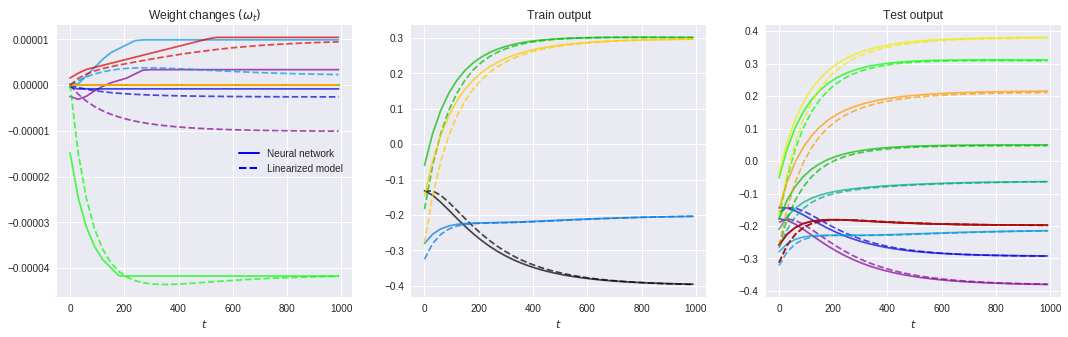

In [0]:
cmap = plt.cm.nipy_spectral
alpha = 0.7

fig, ax = plt.subplots(1,3, figsize=(18,5))

for i in range(n_weights_to_track):  
  ax[0].set_title(r"Weight changes $(\omega_t)$")
  ax[0].set_xlabel(r"$t$")
  ax[0].plot(t_list, weights_analytical_evolution[i], "--", color=cmap(i/n_weights_to_track), alpha=alpha)
  ax[0].plot(t_list, weights_GD_evolution[i], color=cmap(i/n_weights_to_track), alpha=alpha)
   
for i in range(n_train):
  ax[1].set_title(r"Train output")
  ax[1].set_xlabel(r"$t$")
  ax[1].plot(t_list, preds_train_analytical_evolution[i], "--", color=cmap(i/n_train), alpha=alpha)
  ax[1].plot(t_list, preds_train_GD_evolution[i], color=cmap(i/n_train), alpha=alpha)
  
for i in range(n_test):
  ax[2].set_title(r"Test output")
  ax[2].set_xlabel(r"$t$")
  ax[2].plot(t_list, preds_test_analytical_evolution[i], "--", color=cmap(i/n_test), alpha=alpha)
  ax[2].plot(t_list, preds_test_GD_evolution[i], color=cmap(i/n_test), alpha=alpha)
  
custom_lines = [Line2D([0], [0], color="blue", lw=2),
                Line2D([0], [0], color="blue", lw=2, ls="--")]
ax[0].legend(custom_lines, ['Neural network', 'Linearized model'])  # add custom legend

plt.show()

In the above plot, you can see the evolution of 10 randomly selected weights and the evolution of the train and test output both by training of the actual neural network (solid line) and by solving the ODEs obtained by the linearized approximation (dashed line).

## Conclusion

We investigated the recent results obtained in [Jacot et al. (2018)][1], that propose a way to study the convergence of a neural network in the space of the network functions. In particular, when the parameters are trained using gradient descent, the network function evolves according to kernel gradient descent with a new kernel, the neural tangent kernel (NTK). It is possible to study properties of convergence in this function space and relate them to positive definitness of the NTK. 

Moreover, [Jacot et al. (2018)][1] showed that, under the infinite width limit, the NTK at initialization converges to a deterministic kernel, and that this kernel remains constant during training. 

We  also considered the work by [Lee et al. (2019)][2], that, building on the previous results, introduced an approximation to the network function by a linear taylor expansion. Under this approximation, the evolution of the network weights and outputs is determined by simple ODEs, that involve the NTK. They also show that it is possible to find exact solution to this ODEs for least squares regression tasks, and to use ODE solvers for other cases. This means that you don't need to train the network to determine its evolution. The key result of [Lee et al. (2019)][2] is that, under gradient descent and in the limit of infinite width, the network function converges to the linearized one. Therefore, it is theoretically possible to determine the evolution of a network starting from its initial configuration, if it is sufficiently wide.

In the present work, we replicated some simulations present in the above two papers and some new ones. 

Note also that the above theoretical analysis was carried on in the setting of full-batch gradient descent (with optional momentum) in a fully connected network, but [Lee et al. (2019)][2] also performed experiments yielding coherent results to the above argument in different scenarios. It remains a challenge to extend the theoretical results to the latter. 

This line of research seems to be a promising path towards a better understanding of neural network training and, maybe, towards more efficient algorithms. 

[1]: https://arxiv.org/abs/1806.07572
[2]: https://arxiv.org/abs/1902.06720